# Adaptative Annealed Importance Sampling

## AIS within a HMM framework

We want to approximate the posterior distribution of latent states time $t=1$ using Annealed Importance Sampling. The model is a Hidden Markov Model HMM with one observation at time $t=1$. Model components are defined as follows:

* Latent state trayectory: $\{x_{0:1}\}$
* Prior: $f(x_0)$
* Transition model: $f(x_1|x_0)$
* Observations: $y_1$
* Observation model: $g(y_1|x_{0:1})$

We want to approximate the posterior distribution at time $t=1$
$$
p(x_{0:1}|y_1) \propto f(x_0)f(x_1|x_0)g(y_1|x_{0:1}).
$$
Note that the likelihood not only depends on $x_1$ but on the full path $x_{0:1}$.


Let $0=\alpha < \alpha_1 < \cdots < \alpha_K = 1$ define the sequence of intermediate distributions
$$
\pi_k(x_{0:1}|y_1) \propto f(x_0)f(x_1|x_0)g(y_1|x_{0:1})^{\alpha_k}
$$
where the interpolation is defined between
* $k=0$ $(\alpha_0 = 0)$: the joint prior distribution
\begin{align*}
\pi_0(x_{0:1}|y_1) & \propto p(x_{0:1}) \\
                & = f(x_0)f(x_1|x_0).
\end{align*}
* $k=1$ $(\alpha_1 = 1)$: the full posterior distribution
\begin{align*}
\pi_K(x_{0:1}|y_1) & \propto  p(x_{0:1}|y_1) \\
                   & = f(x_0)f(x_1|x_0)g(y_1|x_{0:1}).
\end{align*}

With this in mind, the incremental weight to be used for importance sampling can be computed without loss of generality through:
\begin{align*}
\frac{\pi_k(x_{0:1}|y_1)}{\pi_{k-1}(x_{0:1}|y_1)} & \propto g(y_1|x_{0:1})^{\alpha_k - \alpha_{k-1}} \\
                                                  & = g(y_1|x_{0:1})^{\Delta \alpha_k}
\end{align*}

In [1]:
# Load required libraries
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import matplotlib.cm as cm
import pickle
import os
%matplotlib inline

In [2]:
# Import COVID data
data = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
weekly_covid_df = data.groupby([pd.Grouper(key='date', freq='W-SUN')]).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
print(weekly_covid_df.head())

pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.01% of Population: ', np.round(0.001*N).astype(int))

        date  confirmed_cases  confirmed_deaths
0 2020-02-23              4.0               0.0
1 2020-03-01             23.0               0.0
2 2020-03-08            131.0               0.0
3 2020-03-15            624.0               0.0
4 2020-03-22           1152.0               6.0
Total Population:  126014024
0.01% of Population:  126014


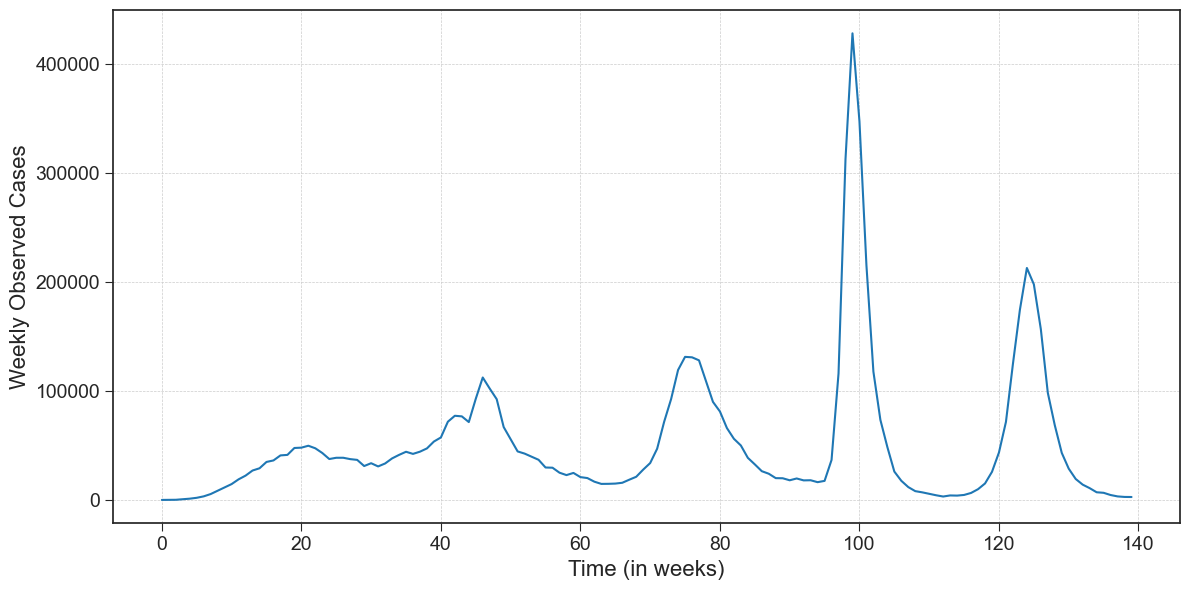

In [3]:
Y_obs = weekly_covid_df['confirmed_cases'].values[:140]

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(Y_obs)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in weeks)', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [62]:
# Functions module 

def BM_SEIR(V_in, params, num_particles, N,m):
    num_steps = m + 1  
    h = 1 / num_steps 

    # Initialize arrays to store results
    V = np.zeros([V_in.shape[0], num_particles, num_steps + 1])    
    new_infected = np.zeros([num_particles])

    # Set initial conditions
    kappa, gamma, sigma = params[:3]    
    V[:,:,0] = V_in

    # Simulate the SIR model with diffuse infectious rate using Euler-Maruyama method
    for t in range(1, num_steps + 1):
        # Update SEIR model
        infections = np.exp(V[4,:,t-1]) * V[0, :, t-1] * V[2, :, t-1] / N 
        latent = kappa * V[1, :, t-1]
        recovered = gamma * V[2, :, t-1]
        
        V[0, :, t] = V[0, :, t-1] - infections*h                  # S-Susceptibles
        V[1, :, t] = V[1, :, t-1] + (infections  - latent)*h    # E-Exposed
        V[2, :, t] = V[2, :, t-1] + (latent - recovered)*h        # I-Infected
        V[3, :, t] = V[3, :, t-1] + recovered*h                   # R-Recovered
        
        # Update Latent State
        dB = stats.norm(0, 1).rvs(num_particles)
        V[4,:,t] = V[4,:,t-1] + sigma * np.sqrt(h) * dB
        
        # Update weekly infected count
        new_infected += infections*h 
    
    return V[:,:,-1], new_infected

def conditional_ess(prev_weights, log_incremental_weights):
    N = len(prev_weights)
        
    # Compute unnormalized incremental weights in log space
    log_w = log_incremental_weights
    max_log_w = np.max(log_w)
    w = np.exp(log_w - max_log_w)
    
    numerator = (np.sum(prev_weights * w))**2
    denominator = np.sum(prev_weights * (w**2))
    
    return N * numerator / denominator

def find_alpha(prev_weights, log_likelihoods, alpha_prev, target_cess, N, tol=1e-5, max_iter=100):
    lower = 0
    upper = 1.0 - alpha_prev
    iteration = 0

    while (upper - lower > tol) and (iteration < max_iter):
        mid = (lower + upper) / 2.0
        log_incremental_weights = mid * log_likelihoods
        cess = conditional_ess(prev_weights, log_incremental_weights)

        if cess >= target_cess * N:
            lower = mid  
        else:
            upper = mid

        iteration += 1
        if(iteration == max_iter):
            print('Max iter reached for find alpha')
    #Añadir un if, que sucede si alpha_k = 1
    #Usar Newton
    delta_alpha = lower
    alpha_new = alpha_prev + delta_alpha

    return delta_alpha, alpha_new


## Initial Tests

In [63]:
# Define prior distributions for model parameters and initial value conditions of the state space model
m = 0
T = Y_obs.shape[0]-1
num_particles = 1000
num_iterations = 150000

E0 = stats.uniform(0,0.0001*N).rvs(num_particles)
I0 = np.ones(num_particles)*Y_obs[0]
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(0,2).rvs(num_particles))
    ])

overdispersion = 0.6212418740345191

current_theta = np.array([
    stats.beta(11.4, 2.5).rvs(),
    stats.beta(12.1, 10.3).rvs(),
    stats.uniform(0,1).rvs()
])

print('Initial conditions: \n',np.mean(initial_conditions, axis=1))
print('Initial parameters: \n',current_theta)


# Initialize BPF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
weekly_infections = np.zeros([num_particles, T+1])

weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])

ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[2, :, 0]

weights[:,0] = 1 / num_particles
norm_weights[:,0] = weights[:,0]
ESS[0] = num_particles

ancestry_matrix[:,0] = np.arange(num_particles)

# Propagate particles to time t=1
particles[:,:,1], weekly_infections[:,1] = BM_SEIR(particles[:, :, 0], current_theta, num_particles, N, m)

# Run Aadaptative Anealing Importance Sampling to estimate latent state posterior at time t=1

# 1. Initialize annealing variables
alpha_prev = 0.0
annealing_schedule = [alpha_prev]
target_cess_ratio = 0.99
tol = 1e-4
max_annealing_steps = 100
annealing_step = 0
ais_log_weights = np.zeros(num_particles)
ais_prev_weights = np.ones(num_particles) / num_particles
ais_log_weights_history = [ais_log_weights.copy()]

# 2. Compute log likelihood of prior state trayectory
log_likelihoods = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,1])).logpmf(Y_obs[1])

# 3. AIS Loop
while (1.0 - alpha_prev > tol) and (annealing_step < max_annealing_steps):
    # 1. Find optimal delta_alpha using bisection and cESS
    delta_alpha, alpha_new = find_alpha(ais_prev_weights, log_likelihoods, alpha_prev, target_cess_ratio, num_particles)
    ais_log_weights += delta_alpha * log_likelihoods
    ais_log_weights_history.append(ais_log_weights.copy())
    
    max_log_w = np.max(ais_log_weights)
    ais_weights = np.exp(ais_log_weights - max_log_w)
    ais_norm_weights = ais_weights / np.sum(ais_weights)
    
    # 2. Resample (at every step) using Systematic Resampling  
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(ais_norm_weights), positions)
    
    particles[:,:,:1] = particles[:,resample_indices,:1]
    weekly_infections[:,:1] = weekly_infections[resample_indices,:1]
    ais_log_weights[:] = 0
    
    # 3. Recompute likelihoods for resampled particles
    log_likelihoods = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,1])).logpmf(Y_obs[1])
    
    # 3. MCMC Jitter
    for mcmc_iter in range(5):  # 10 jitter steps
        proposed_betas = particles[-1, :, 0] + np.random.normal(0, 0.5 * np.std(particles[-1, :, 0]), size=particles.shape[1])
        valid_mask = (np.exp(proposed_betas) < 2) & (np.exp(proposed_betas) > 0)
        if not np.any(valid_mask):
            continue 
        proposed_states = particles[:, :, 0].copy()
        proposed_states[-1, valid_mask] = proposed_betas[valid_mask]
    
        proposed_next_states, proposed_infs = BM_SEIR(proposed_states[:, valid_mask], current_theta, valid_mask.sum(), N, m)
        proposed_ll = stats.nbinom(n=1 / overdispersion,p=1 / (1 + overdispersion * proposed_infs)).logpmf(Y_obs[1])
        current_ll = log_likelihoods[valid_mask]

        # Compute acceptance probabilities
        log_accept_ratios = alpha_new * (proposed_ll - current_ll)
        accept = np.log(np.random.rand(valid_mask.sum())) < log_accept_ratios

        # Update accepted particles
        idxs = np.where(valid_mask)[0][accept]
        particles[-1, idxs, 0] = proposed_betas[idxs]
        particles[:, idxs, 1] = proposed_next_states[:, accept]
        weekly_infections[idxs, 1] = proposed_infs[accept]
        log_likelihoods[idxs] = proposed_ll[accept]
        
    # 4. Update loop variables
    alpha_prev = alpha_new
    annealing_schedule.append(alpha_prev)
    annealing_step += 1
    if(annealing_step == max_annealing_steps-1):
            print('Max iter reached for annealing schedule')

Initial conditions: 
 [ 1.26007528e+08  6.49179463e+03  4.00000000e+00  0.00000000e+00
 -3.50626113e-01]
Initial parameters: 
 [0.9017679  0.52092018 0.24207307]


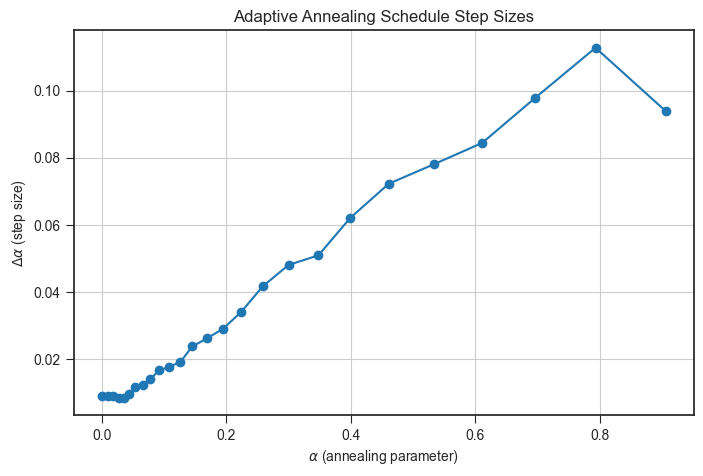

In [64]:
# Compute delta alphas (step sizes)
delta_alphas = np.diff(annealing_schedule)
alphas_mid = annealing_schedule[:-1]  # plot against the starting alpha of each step

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alphas_mid, delta_alphas, marker='o')
plt.xlabel(r'$\alpha$ (annealing parameter)')
plt.ylabel(r'$\Delta \alpha$ (step size)')
plt.title('Adaptive Annealing Schedule Step Sizes')
plt.grid(True)
plt.show()

In [65]:
def run_mcmc_jitter(particles_t, particles_tplus1, log_likelihoods, Y_obs_t, alpha, overdispersion, N):
    num_particles = particles_t.shape[1]
    for mcmc_iter in range(1):  # fixed number of MCMC loops
        proposed_betas = particles_t[-1] + np.random.normal(0, 0.5*np.std(particles_t[-1]), size=num_particles)
        valid_mask = (np.exp(proposed_betas) < 2) & (np.exp(proposed_betas) > 0)

        if not np.any(valid_mask):
            continue

        proposed_states = particles_t.copy()
        proposed_states[-1, valid_mask] = proposed_betas[valid_mask]
        
        proposed_next_states, proposed_infs = BM_SEIR(proposed_states[:, valid_mask], current_theta, valid_mask.sum(), N, 0)
        proposed_ll = stats.nbinom(n=1 / overdispersion, p=1 / (1 + overdispersion * proposed_infs)).logpmf(Y_obs_t)
        current_ll = log_likelihoods[valid_mask]

        log_accept_ratios = alpha * (proposed_ll - current_ll)
        accept = np.log(np.random.rand(valid_mask.sum())) < log_accept_ratios

        idxs = np.where(valid_mask)[0][accept]
        particles_t[-1, idxs] = proposed_betas[idxs]
        particles_tplus1[:, idxs] = proposed_next_states[:, accept]
        log_likelihoods[idxs] = proposed_ll[accept]

    return particles_t, particles_tplus1, log_likelihoods

def run_adaptive_ais_step(particles_t, particles_tplus1, log_likelihoods, Y_obs_t, N, alpha_prev, target_cess_ratio, overdispersion):
    num_particles = particles_t.shape[1]
    ais_log_weights = np.zeros(num_particles)
    ais_log_weights_history = [ais_log_weights.copy()]
    annealing_schedule = [alpha_prev]
    tol = 1e-4
    max_annealing_steps = 100
    annealing_step = 0

    while (1.0 - alpha_prev > tol) and (annealing_step < max_annealing_steps):
        delta_alpha, alpha_new = find_alpha(
            prev_weights=np.ones(num_particles) / num_particles,
            log_likelihoods=log_likelihoods,
            alpha_prev=alpha_prev,
            target_cess=target_cess_ratio,
            N=num_particles
        )

        ais_log_weights += delta_alpha * log_likelihoods
        ais_log_weights_history.append(ais_log_weights.copy())

        max_log_w = np.max(ais_log_weights)
        ais_weights = np.exp(ais_log_weights - max_log_w)
        ais_norm_weights = ais_weights / np.sum(ais_weights)

        # Resample
        r = np.random.uniform()
        positions = (np.arange(num_particles) + r) / num_particles
        resample_indices = np.searchsorted(np.cumsum(ais_norm_weights), positions)

        particles_t = particles_t[:, resample_indices]
        particles_tplus1 = particles_tplus1[:, resample_indices]

        # Reset weights
        ais_log_weights[:] = 0

        # Recompute log-likelihoods
        ll = stats.nbinom(n=1/overdispersion, p=1/(1 + overdispersion * particles_tplus1[2])).logpmf(Y_obs_t)
        log_likelihoods = ll

        # MCMC jitter
        particles_t, particles_tplus1, log_likelihoods = run_mcmc_jitter(
            particles_t, particles_tplus1, log_likelihoods, Y_obs_t, alpha_new, overdispersion, N
        )

        alpha_prev = alpha_new
        annealing_schedule.append(alpha_prev)
        annealing_step += 1

    return particles_t, particles_tplus1, log_likelihoods

In [66]:
for t in range(1, T+1):
    # Propagate
    particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:,:,t-1], current_theta, num_particles, N, m)

    # Compute initial log-likelihoods
    log_likelihoods = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,t])).logpmf(Y_obs[t])

    # Run AIS + MCMC at time t
    particles[:,:,t-1], particles[:,:,t], log_likelihoods = run_adaptive_ais_step(
        particles[:,:,t-1], particles[:,:,t], log_likelihoods, Y_obs[t], N, alpha_prev=0.0,
        target_cess_ratio=0.99, overdispersion=overdispersion
    )

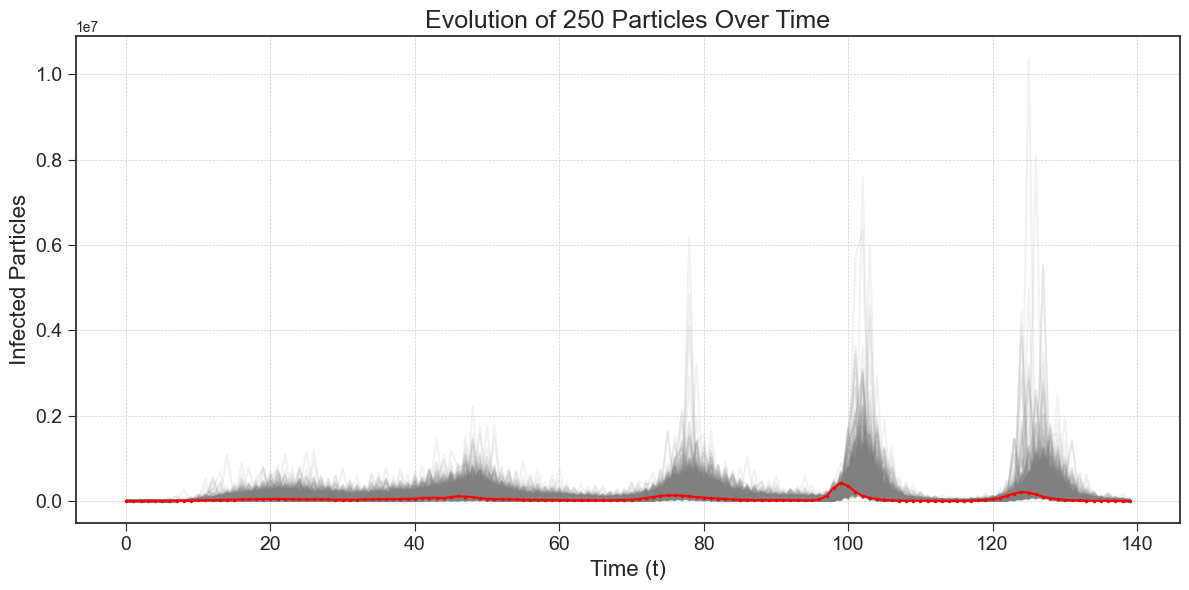

In [67]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

for i in range(0,1000):
    plt.plot(weekly_infections[i,:], color='grey', alpha=0.1)
plt.plot(Y_obs, color='r', marker='o', markersize=1.5)

plt.xlabel('Time (t)', fontsize=16)
plt.ylabel('Infected Particles', fontsize=16)
plt.title('Evolution of 250 Particles Over Time', fontsize=18)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

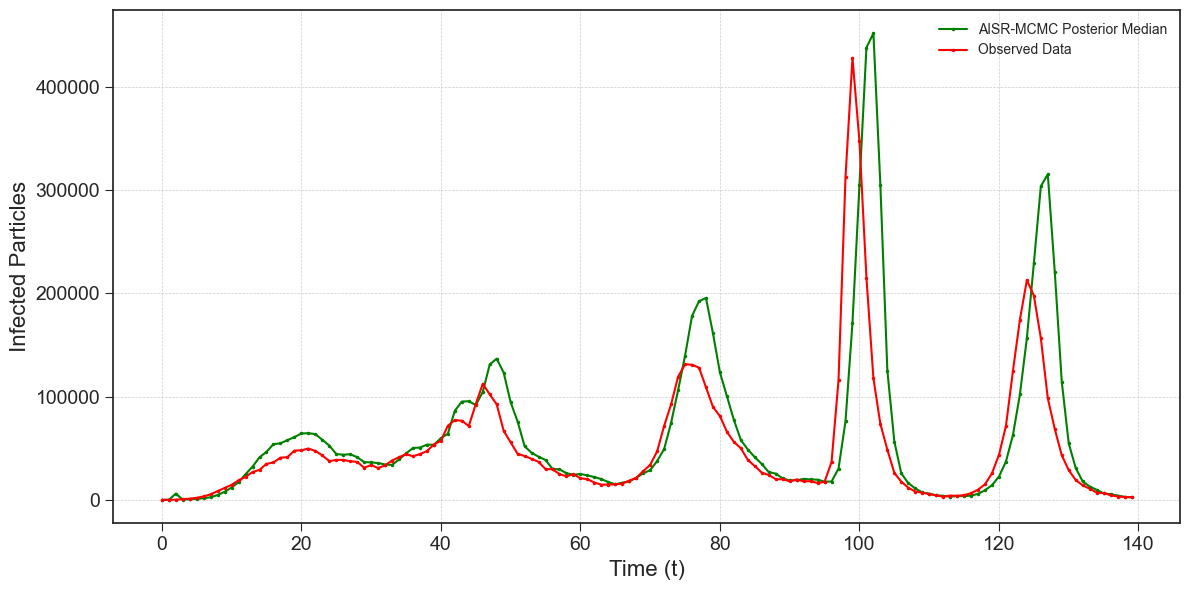

In [69]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')


plt.plot(np.median(weekly_infections, axis=0), color='g', marker='o', markersize=1.5, label='AISR-MCMC Posterior Median')
plt.plot(Y_obs, color='r', marker='o', markersize=1.5, label='Observed Data')

plt.xlabel('Time (t)', fontsize=16)
plt.ylabel('Infected Particles', fontsize=16)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.legend()
plt.show()

## Updating AISR and Find Alpha AISR Functions

In [70]:
def find_alpha_AISR(
    prev_weights,               # previous step weights for CESS (since we resample at every step they are always 1/N)
    log_incremental_weights,    # log p(y_t | x_t^{(i)})
    alpha_prev,                 # previous annealing level
    target_cess_ratio,          # target cESS ratio (e.g. 0.99)
    num_particles,              # number of particles
    tol=1e-4,
    max_iter=100
):
    lower_bound = 0.0
    upper_bound = 1.0 - alpha_prev
    iteration = 0

    while (upper_bound - lower_bound > tol) and (iteration < max_iter):
        delta_alpha_candidate = 0.5 * (lower_bound + upper_bound)

        # Incremental log weights for proposed delta alpha
        log_weight_update = delta_alpha_candidate * log_incremental_weights
        cess_candidate = conditional_ess(prev_weights, log_weight_update)

        if cess_candidate >= target_cess_ratio * num_particles:
            lower_bound = delta_alpha_candidate
        else:
            upper_bound = delta_alpha_candidate

        iteration += 1

    # Final delta alpha and new alpha
    delta_alpha_opt = lower_bound
    alpha_new = alpha_prev + delta_alpha_opt

    return delta_alpha_opt, alpha_new

In [71]:
# Define prior distributions for model parameters and initial value conditions of the state space model
m = 0
T = Y_obs.shape[0]-1
num_particles = 1000
num_iterations = 150000

E0 = stats.uniform(0,0.0001*N).rvs(num_particles)
I0 = np.ones(num_particles)*Y_obs[0]
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(0,2).rvs(num_particles))
    ])

overdispersion = 0.6212418740345191

current_theta = np.array([
    stats.beta(11.4, 2.5).rvs(),
    stats.beta(12.1, 10.3).rvs(),
    stats.uniform(0,1).rvs()
])

print('Initial conditions: \n',np.mean(initial_conditions, axis=1))
print('Initial parameters: \n',current_theta)


# Initialize BPF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
weekly_infections = np.zeros([num_particles, T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])
ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[2, :, 0]
weights[:,0] = 1 / num_particles
norm_weights[:,0] = weights[:,0]
ancestry_matrix[:,0] = np.arange(num_particles)
ESS[0] = num_particles

# Propagate particles to time t=1
particles[:,:,1], weekly_infections[:,1] = BM_SEIR(particles[:, :, 0], current_theta, num_particles, N, m)

log_incremental_weights = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,1])).logpmf(Y_obs[1])
max_log_weights = np.max(log_incremental_weights)
weights[:,1] = np.exp(log_incremental_weights - max_log_weights)
sum_weights = weights[:,1].sum()
norm_weights[:,1] = weights[:,1] / sum_weights
        
ESS[1] = 1 / (np.sum(norm_weights[:,1]**2))
loglikelihood += max_log_weights + np.log(sum_weights) - np.log(num_particles)
        
# Run Aadaptative Anealing Importance Sampling to estimate latent state posterior at time t=1

# 1. Initialize annealing variables
alpha_prev = 0.0
annealing_schedule = [alpha_prev]
target_cess_ratio = 0.99
tol = 1e-4
max_annealing_steps = 100
annealing_step = 0

prev_weights = np.ones(num_particles) / num_particles
ais_log_weights = np.zeros(num_particles) 

# 2. AIS Loop
while (1.0 - alpha_prev > tol) and (annealing_step < max_annealing_steps):
    # 1. Find optimal delta_alpha using bisection and cESS
    delta_alpha, alpha_new = find_alpha_AISR(prev_weights, log_incremental_weights, alpha_prev, target_cess_ratio, num_particles)
    
    # 2. Update log weights based on current delta_alpha (since weights were reset after resampling)
    ais_log_weights = delta_alpha * log_incremental_weights
    
    # 3. Normalize weights for stability
    max_ais_log_w = np.max(ais_log_weights)
    ais_weights = np.exp(ais_log_weights - max_log_w)
    ais_norm_weights = ais_weights / np.sum(ais_weights)
    
    # 4. Resample    
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(ais_norm_weights), positions)
    
    particles[:,:,1] = particles[:,resample_indices,1]
    weekly_infections[:,1] = weekly_infections[resample_indices,1]
    
    # 5. Recompute incremental log weights for next round
    log_incremental_weights = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,1])).logpmf(Y_obs[1])
    
    # 6. Reset weights and update alpha
    ais_log_weights[:] = 0
    alpha_prev = alpha_new
    annealing_schedule.append(alpha_prev)
    annealing_step += 1

    if annealing_step == max_annealing_steps:
        print('Max AIS iterations reached')

Initial conditions: 
 [ 1.26007736e+08  6.28392427e+03  4.00000000e+00  0.00000000e+00
 -3.24889239e-01]
Initial parameters: 
 [0.96725814 0.46266347 0.73840803]


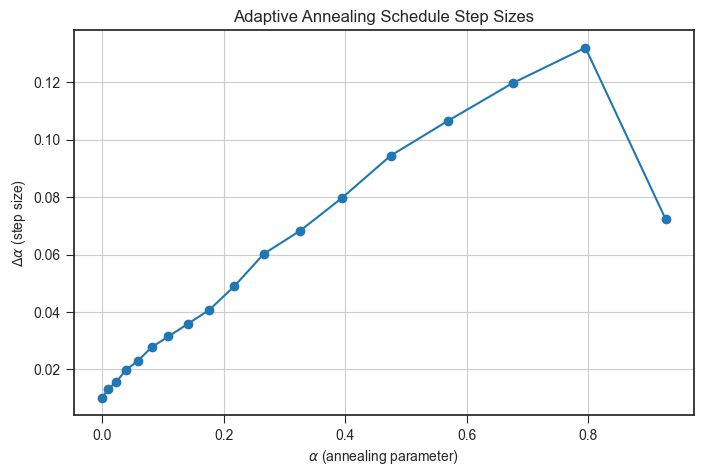

In [72]:
# Compute delta alphas (step sizes)
delta_alphas = np.diff(annealing_schedule)
alphas_mid = annealing_schedule[:-1]  # plot against the starting alpha of each step

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alphas_mid, delta_alphas, marker='o')
plt.xlabel(r'$\alpha$ (annealing parameter)')
plt.ylabel(r'$\Delta \alpha$ (step size)')
plt.title('Adaptive Annealing Schedule Step Sizes')
plt.grid(True)
plt.show()

#### Using Newton for find Alpha

In [73]:
from scipy.optimize import newton
import numpy as np

def log_cess_resampling(alpha, alpha_t, log_liks):
    delta = alpha - alpha_t
    w = np.exp(delta * log_liks)
    S1 = np.sum(w)
    S2 = np.sum(w ** 2)
    return 2 * np.log(S1) - np.log(S2)

def d_log_cess_resampling(alpha, alpha_t, log_liks):
    delta = alpha - alpha_t
    w = np.exp(delta * log_liks)
    S1 = np.sum(w)
    S2 = np.sum(w ** 2)
    E1 = np.sum(log_liks * w) / S1
    E2 = np.sum(log_liks * (w ** 2)) / S2
    return 2 * E1 - 2 * E2

def find_alpha_newton(alpha_prev, log_likelihoods, target_cess_ratio, tol=1e-4):
    N = len(log_likelihoods)
    target_log_cess = np.log(target_cess_ratio * N)

    f = lambda alpha: log_cess_resampling(alpha, alpha_prev, log_likelihoods) - target_log_cess
    fprime = lambda alpha: d_log_cess_resampling(alpha, alpha_prev, log_likelihoods)
    
    # Initial guess: small step forward
    alpha_init = min(alpha_prev + 0.005, 1.0)

    try:
        alpha_star = newton(func=f, x0=alpha_init, tol=tol, maxiter=10)
        alpha_star = np.clip(alpha_star, alpha_prev + 1e-4, 1.0)
    except RuntimeError:
        alpha_star = min(alpha_prev + 0.005, 1.0)

    delta_alpha = alpha_star - alpha_prev
    return delta_alpha, alpha_star

def log_cess_general(alpha, alpha_t, log_likelihoods, prev_weights):
    delta = alpha - alpha_t
    w = np.exp(delta * log_likelihoods)

    num = np.sum(prev_weights * w)
    denom = np.sum(prev_weights * (w ** 2))
    
    return 2 * np.log(num) - np.log(denom)

def find_alpha_general(alpha_prev, log_likelihoods, prev_weights, target_cess_ratio, tol=1e-4):
    N = len(log_likelihoods)
    target_log_cess = np.log(target_cess_ratio * N)

    def f(alpha):
        return log_cess_general(alpha, alpha_prev, log_likelihoods, prev_weights) - target_log_cess

    # Initial guess: small step forward
    alpha_init = min(alpha_prev + 0.01, 1.0)

    try:
        alpha_star = newton(func=f, x0=alpha_init, tol=tol, maxiter=10)
        alpha_star = np.clip(alpha_star, alpha_prev + 1e-4, 1.0)
    except RuntimeError:
        alpha_star = min(alpha_prev + 0.01, 1.0)

    delta_alpha = alpha_star - alpha_prev
    return delta_alpha, alpha_star

In [74]:
# Define prior distributions for model parameters and initial value conditions of the state space model
m = 0
T = Y_obs.shape[0]-1
num_particles = 1000
num_iterations = 150000

E0 = stats.uniform(0,0.0001*N).rvs(num_particles)
I0 = np.ones(num_particles)*Y_obs[0]
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(0,2).rvs(num_particles))
    ])

overdispersion = 0.6212418740345191

current_theta = np.array([
    stats.beta(11.4, 2.5).rvs(),
    stats.beta(12.1, 10.3).rvs(),
    stats.uniform(0,1).rvs()
])

print('Initial conditions: \n',np.mean(initial_conditions, axis=1))
print('Initial parameters: \n',current_theta)


# Initialize BPF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
weekly_infections = np.zeros([num_particles, T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])
ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[2, :, 0]
weights[:,0] = 1 / num_particles
norm_weights[:,0] = weights[:,0]
ancestry_matrix[:,0] = np.arange(num_particles)
ESS[0] = num_particles

# Propagate particles to time t=1
particles[:,:,1], weekly_infections[:,1] = BM_SEIR(particles[:, :, 0], current_theta, num_particles, N, m)

log_incremental_weights = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,1])).logpmf(Y_obs[1])
max_log_weights = np.max(log_incremental_weights)
weights[:,1] = np.exp(log_incremental_weights - max_log_weights)
sum_weights = weights[:,1].sum()
norm_weights[:,1] = weights[:,1] / sum_weights
        
ESS[1] = 1 / (np.sum(norm_weights[:,1]**2))
loglikelihood += max_log_weights + np.log(sum_weights) - np.log(num_particles)
        
# Run Aadaptative Anealing Importance Sampling to estimate latent state posterior at time t=1

# 1. Initialize annealing variables
alpha_prev = 0.0
annealing_schedule = [alpha_prev]
target_cess_ratio = 0.99
tol = 1e-4
max_annealing_steps = 100
annealing_step = 0

prev_weights = np.ones(num_particles) / num_particles
ais_log_weights = np.zeros(num_particles) 

# 2. AIS Loop
while (1.0 - alpha_prev > tol) and (annealing_step < max_annealing_steps):
    # 1. Find optimal delta_alpha using Newton and cESS    
    delta_alpha, alpha_new = find_alpha_newton(
    alpha_prev=alpha_prev,
    log_likelihoods=log_incremental_weights,
    target_cess_ratio=target_cess_ratio
)
    
    # 2. Update log weights based on current delta_alpha (since weights were reset after resampling)
    ais_log_weights = delta_alpha * log_incremental_weights
    
    # 3. Normalize weights for stability
    max_ais_log_w = np.max(ais_log_weights)
    ais_weights = np.exp(ais_log_weights - max_log_w)
    ais_norm_weights = ais_weights / np.sum(ais_weights)
    
    # 4. Resample    
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(ais_norm_weights), positions)
    
    particles[:,:,1] = particles[:,resample_indices,1]
    weekly_infections[:,1] = weekly_infections[resample_indices,1]
    
    # 5. Recompute incremental log weights for next round
    log_incremental_weights = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,1])).logpmf(Y_obs[1])
    
    # 6. Reset weights and update alpha
    ais_log_weights[:] = 0
    alpha_prev = alpha_new
    annealing_schedule.append(alpha_prev)
    annealing_step += 1

    if annealing_step == max_annealing_steps:
        print('Max AIS iterations reached')

Initial conditions: 
 [ 1.26007724e+08  6.29638151e+03  4.00000000e+00  0.00000000e+00
 -2.81556970e-01]
Initial parameters: 
 [0.86451308 0.62575027 0.29219866]


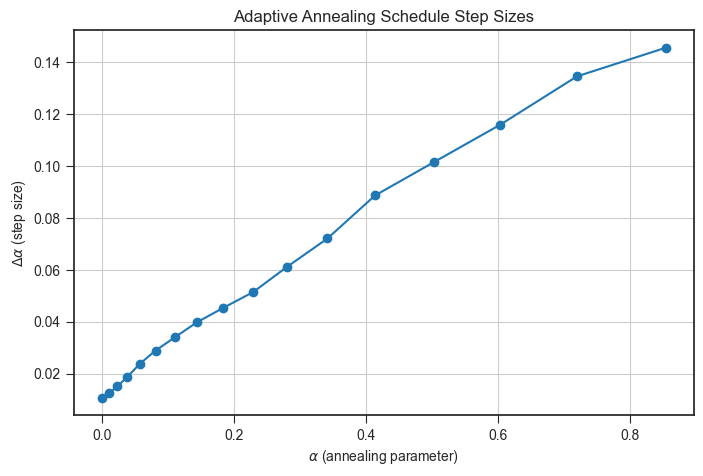

In [75]:
# Compute delta alphas (step sizes)
delta_alphas = np.diff(annealing_schedule)
alphas_mid = annealing_schedule[:-1]  # plot against the starting alpha of each step

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alphas_mid, delta_alphas, marker='o')
plt.xlabel(r'$\alpha$ (annealing parameter)')
plt.ylabel(r'$\Delta \alpha$ (step size)')
plt.title('Adaptive Annealing Schedule Step Sizes')
plt.grid(True)
plt.show()

In [76]:
def run_adaptive_ais_step(particles_t, particles_tplus1, log_likelihoods, Y_obs_t, N, alpha_prev, target_cess_ratio, overdispersion):
    num_particles = particles_t.shape[1]
    ais_log_weights = np.zeros(num_particles)
    ais_log_weights_history = [ais_log_weights.copy()]
    annealing_schedule = [alpha_prev]
    tol = 1e-4
    max_annealing_steps = 100
    annealing_step = 0

    while (1.0 - alpha_prev > tol) and (annealing_step < max_annealing_steps):
        # 1. Find optimal delta_alpha using Newton and cESS    
        delta_alpha, alpha_new = find_alpha_newton(alpha_prev=alpha_prev,log_likelihoods=log_likelihoods, target_cess_ratio=target_cess_ratio)
        
        # 2. Update log weights based on current delta_alpha
        ais_log_weights += delta_alpha * log_likelihoods
        ais_log_weights_history.append(ais_log_weights.copy())

        max_log_w = np.max(ais_log_weights)
        ais_weights = np.exp(ais_log_weights - max_log_w)
        ais_norm_weights = ais_weights / np.sum(ais_weights)

        # Resample
        r = np.random.uniform()
        positions = (np.arange(num_particles) + r) / num_particles
        resample_indices = np.searchsorted(np.cumsum(ais_norm_weights), positions)

        particles_t = particles_t[:, resample_indices]
        particles_tplus1 = particles_tplus1[:, resample_indices]

        # Reset weights
        ais_log_weights[:] = 0

        # Recompute log-likelihoods
        log_likelihoods = stats.nbinom(n=1/overdispersion, p=1/(1 + overdispersion * particles_tplus1[2])).logpmf(Y_obs_t)

        # MCMC jitter
        particles_t, particles_tplus1, log_likelihoods = run_mcmc_jitter(
            particles_t, particles_tplus1, log_likelihoods, Y_obs_t, alpha_new, overdispersion, N
        )

        alpha_prev = alpha_new
        annealing_schedule.append(alpha_prev)
        annealing_step += 1

    return particles_t, particles_tplus1, log_likelihoods

In [83]:
# Define prior distributions for model parameters and initial value conditions of the state space model
m = 0
T = Y_obs.shape[0]-1
num_particles = 1000
num_iterations = 150000

E0 = stats.uniform(0,0.0001*N).rvs(num_particles)
I0 = np.ones(num_particles)*Y_obs[0]
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(0,2).rvs(num_particles))
    ])

overdispersion = 0.6212418740345191

current_theta = np.array([
    stats.beta(11.4, 2.5).rvs(),
    stats.beta(12.1, 10.3).rvs(),
    stats.uniform(0,1).rvs()
])

print('Initial conditions: \n',np.mean(initial_conditions, axis=1))
print('Initial parameters: \n',current_theta)


# Initialize BPF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
weekly_infections = np.zeros([num_particles, T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])
ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[2, :, 0]
weights[:,0] = 1 / num_particles
norm_weights[:,0] = weights[:,0]
ancestry_matrix[:,0] = np.arange(num_particles)
ESS[0] = num_particles


for t in range(1, T+1):
    # Propagate
    particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:,:,t-1], current_theta, num_particles, N, m)

    # Compute initial log-likelihoods
    log_likelihoods = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,t])).logpmf(Y_obs[t])

    # Run AIS + MCMC at time t
    particles[:,:,t-1], particles[:,:,t], log_likelihoods = run_adaptive_ais_step(
        particles[:,:,t-1], particles[:,:,t], log_likelihoods, Y_obs[t], N, alpha_prev=0.0,
        target_cess_ratio=0.99, overdispersion=overdispersion
    )

Initial conditions: 
 [ 1.26007703e+08  6.31723117e+03  4.00000000e+00  0.00000000e+00
 -3.54346875e-01]
Initial parameters: 
 [0.86989792 0.43777157 0.21506162]


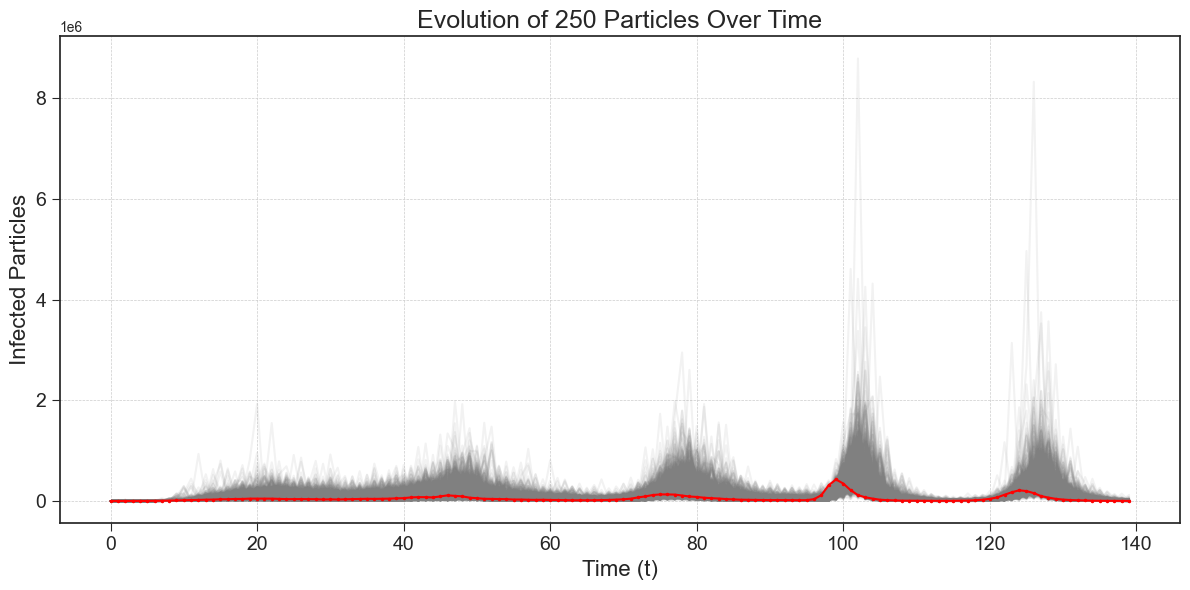

In [84]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

for i in range(0,1000):
    plt.plot(weekly_infections[i,:], color='grey', alpha=0.1)
plt.plot(Y_obs, color='r', marker='o', markersize=1.5)

plt.xlabel('Time (t)', fontsize=16)
plt.ylabel('Infected Particles', fontsize=16)
plt.title('Evolution of 250 Particles Over Time', fontsize=18)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

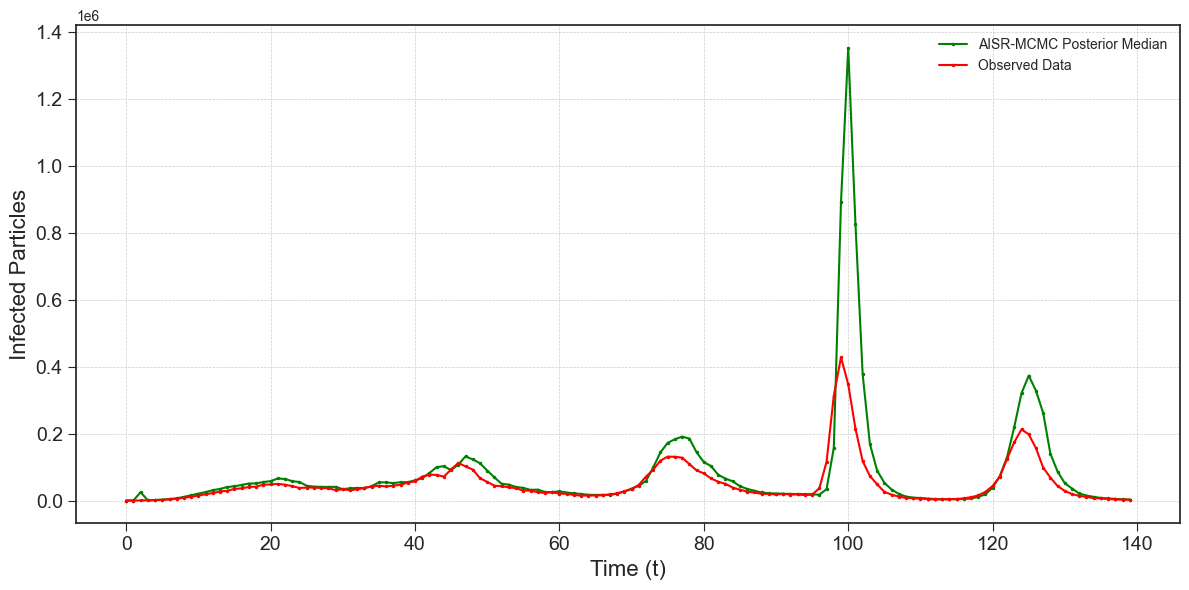

In [54]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')


plt.plot(np.median(weekly_infections, axis=0), color='g', marker='o', markersize=1.5, label='AISR-MCMC Posterior Median')
plt.plot(Y_obs, color='r', marker='o', markersize=1.5, label='Observed Data')

plt.xlabel('Time (t)', fontsize=16)
plt.ylabel('Infected Particles', fontsize=16)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.legend()
plt.show()

## BPF with AIS and MCMC Jitter (using Newton to find $\alpha$)

In [21]:
def AIS_BPF(Y_obs, N, T, num_particles, params, initial_conditions, BM_SEIR, m):
    # Initialize BPF variables
    particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
    weekly_infections = np.zeros([num_particles, T+1])

    weights = np.zeros([num_particles, T+1])
    norm_weights = np.zeros([num_particles, T+1])

    ancestry_matrix = np.zeros([num_particles, T+1])
    ESS = np.zeros(T+1)
    loglikelihood = 0

    # Define values at time t=0
    particles[:, :, 0] = initial_conditions
    weekly_infections[:,0] = particles[2, :, 0]

    weights[:,0] = 1 / num_particles
    norm_weights[:,0] = weights[:,0]
    ESS[0] = num_particles

    resample_indices = np.arange(num_particles)
    ancestry_matrix[:,0] = resample_indices
    
    for t in range(1, T+1):
        if t!=1:
            # Resample particles using Systematic Resampling
            r = stats.uniform(0,1).rvs()
            positions =  (np.arange(num_particles) + r )/num_particles
            resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t-1]), positions)
            ancestry_matrix[:,1:t-1] = ancestry_matrix[resample_indices,1:t-1]
            ancestry_matrix[:,t] = resample_indices
        
        # Propagate
        particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:,resample_indices,t-1], current_theta, num_particles, N, m)
    
        # Compute initial log-likelihoods
        log_likelihoods = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,t])).logpmf(Y_obs[t])
    
        # Run AIS + MCMC at time t
        particles[:,:,t-1], particles[:,:,t], log_likelihoods = run_adaptive_ais_step(
            particles[:,:,t-1], particles[:,:,t], log_likelihoods, Y_obs[t], N, alpha_prev=0.0,
            target_cess_ratio=0.99, overdispersion=overdispersion
        )
        
        max_weights = np.max(log_likelihoods)
        weights[:,t] = np.exp(log_likelihoods - max_weights)
        sum_weights = weights[:,t].sum()
        norm_weights[:,t] = weights[:,t] / sum_weights

        ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
        loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)

        if np.isnan(loglikelihood):
            print("Loglikelihood is NaN")
            break
                
    if norm_weights[:,-1].sum() != 1:
        chosen_index = np.random.choice(a=np.arange(num_particles), size=1, p=np.ones(num_particles)/num_particles)
    else:
        chosen_index = np.random.choice(a=np.arange(num_particles), size=1, p=norm_weights[:, -1])
    
    return loglikelihood, weekly_infections[ancestry_matrix[chosen_index, -1].astype(int),:], particles[:,ancestry_matrix[chosen_index, -1].astype(int),:]

In [22]:
# Define prior distributions for model parameters and initial value conditions of the state space model
m = 0
T = Y_obs.shape[0]-1
num_particles = 100

E0 = stats.uniform(0,0.0001*N).rvs(num_particles)
I0 = np.ones(num_particles)*Y_obs[0]
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(0,2).rvs(num_particles))
    ])

overdispersion = 0.6212418740345191

current_theta = np.array([
    stats.beta(11.4, 2.5).rvs(),
    stats.beta(12.1, 10.3).rvs(),
    stats.uniform(0,1).rvs()
])

print('Initial conditions: \n',np.mean(initial_conditions, axis=1))
print('Initial parameters: \n',current_theta)


LL, infection_trayectory, particles_trayectory = AIS_BPF(Y_obs, N, T, num_particles, current_theta, initial_conditions, BM_SEIR, m)
    

Initial conditions: 
 [ 1.26007928e+08  6.09160184e+03  4.00000000e+00  0.00000000e+00
 -3.21150716e-01]
Initial parameters: 
 [0.90611709 0.51196064 0.76298599]


# PF-MCMC

In [23]:
m = 0
T = Y_obs.shape[0]-1
num_particles = 300
num_iterations = 100000

# initial_conditions = np.repeat(V_in,num_particles).reshape(5,num_particles) #Sationary Initial Conditions
E0 = stats.uniform(0,0.0001*N).rvs(num_particles)
I0 = np.ones(num_particles)*Y_obs[0]
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(0,2).rvs(num_particles))
    ])

current_theta = np.array([
    stats.beta(11.4, 2.5).rvs(),
    stats.beta(12.1, 10.3).rvs(),
    stats.uniform(0,1).rvs()
])

stepSize = np.diag([
    0.1**2,
    0.1**2,
    0.1**2,
])

print('Initial conditions: ',np.mean(initial_conditions, axis=1))
print('Initial parameters: ',current_theta)

theta_samples = np.zeros([current_theta.shape[0],num_iterations])
weekly_trajectories = np.zeros([T+1,num_iterations])
vector_trajectories = np.zeros([initial_conditions.shape[0],T+1,num_iterations])
loglikelihoods = np.zeros(num_iterations)

rejected_count = 0
acceptance_count = 0
AccRate = 0

current_loglik, current_weekly, current_vectors  = AIS_BPF(Y_obs, N, T, num_particles, current_theta, initial_conditions, BM_SEIR, m)

print("Initial parameters:", current_theta)
print("Initial log-likelihood:", current_loglik)


Initial conditions:  [ 1.26007853e+08  6.16676307e+03  4.00000000e+00  0.00000000e+00
 -3.55935189e-01]
Initial parameters:  [0.7136975  0.46035578 0.01926247]


/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_75385/2769995193.py:9: RuntimeWarning: divide by zero encountered in log
  return 2 * np.log(S1) - np.log(S2)


Initial parameters: [0.7136975  0.46035578 0.01926247]
Initial log-likelihood: -1569.4716239130555


In [24]:
import time

theta_samples[:,0] = current_theta
loglikelihoods[0] = current_loglik
weekly_trajectories[:,0] = current_weekly
vector_trajectories[:,:,0] = current_vectors[:,0,:]

start_time = time.time()  #start clock
for i in range(1,num_iterations):
    iter_start = time.time()  #per-iteration timing

    proposed_theta = theta_samples[:, i-1] + stats.multivariate_normal(mean=np.zeros(current_theta.shape[0]), cov=stepSize).rvs()
    
    if (proposed_theta[0] < 0) or (proposed_theta[0] > 1) or (proposed_theta[1] < 0) or (proposed_theta[1] > 1)  or (proposed_theta[2] < 0) or (proposed_theta[2] > 1):
        rejected_count += 1
        proposed_loglik = -np.inf
        accept_prob = 0
    else:
        proposed_loglik, proposed_weekly, proposed_vectors  = AIS_BPF(Y_obs, N, T, num_particles, proposed_theta, initial_conditions, BM_SEIR,m)
        prior_ratio = stats.beta(11.4, 2.5).logpdf(proposed_theta[0]) - stats.beta(11.4, 2.5).logpdf(theta_samples[0,i-1])
        prior_ratio += stats.beta(12.1, 10.3).logpdf(proposed_theta[1]) - stats.beta(12.1, 10.3).logpdf(theta_samples[1,i-1])
        log_lik_ratio = proposed_loglik - loglikelihoods[i-1]
        accept_prob = min(1,np.exp(log_lik_ratio + prior_ratio))
    
    if stats.uniform(0,1).rvs() < accept_prob:
        theta_samples[:,i] = proposed_theta
        weekly_trajectories[:,i] = proposed_weekly
        vector_trajectories[:,:,i] = proposed_vectors[:,0,:]
        
        loglikelihoods[i] = proposed_loglik
        acceptance_count += 1
    else:
        theta_samples[:,i] = theta_samples[:,i-1]
        weekly_trajectories[:,i] = weekly_trajectories[:,i-1]
        vector_trajectories[:,:,i] = vector_trajectories[:,:,i-1]

        loglikelihoods[i] = loglikelihoods[i-1]
        
    AccRate = acceptance_count / (i + 1)
    
    if i == 10:
        elapsed = time.time() - start_time
        iter_time = time.time() - iter_start
        print(f"Iteration {i}/{num_iterations}: "
              f"Acceptance Rate = {AccRate:.2%} | "
              f"Rejected = {rejected_count} | "
              f"Elapsed = {elapsed/60:.2f} min | "
              f"Last iter = {iter_time:.2f} s")
        
    if i == 100:
        elapsed = time.time() - start_time
        iter_time = time.time() - iter_start
        print(f"Iteration {i}/{num_iterations}: "
              f"Acceptance Rate = {AccRate:.2%} | "
              f"Rejected = {rejected_count} | "
              f"Elapsed = {elapsed/60:.2f} min | "
              f"Last iter = {iter_time:.2f} s")
        
    if i % 10000 == 0:
        elapsed = time.time() - start_time
        iter_time = time.time() - iter_start
        print(f"Iteration {i}/{num_iterations}: "
              f"Acceptance Rate = {AccRate:.2%} | "
              f"Rejected = {rejected_count} | "
              f"Elapsed = {elapsed/60:.2f} min | "
              f"Last iter = {iter_time:.2f} s")
        

/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_75385/2769995193.py:9: RuntimeWarning: divide by zero encountered in log
  return 2 * np.log(S1) - np.log(S2)
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_75385/2769995193.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  return 2 * np.log(S1) - np.log(S2)


KeyboardInterrupt: 

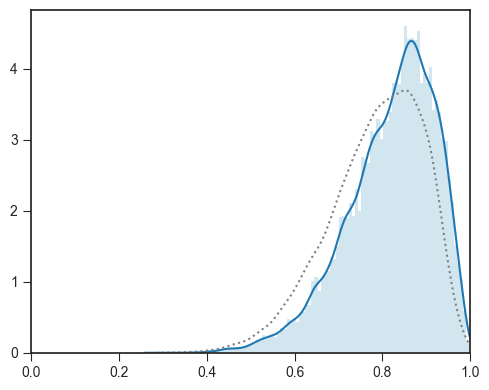

0.8195046555485292


In [68]:
plt.figure(figsize=(5, 4))
plt.hist(
    theta_samples[0, 50000:], 
    bins=100, 
    color=colors[0], 
    density=True,  
    edgecolor='none',
    alpha=0.5
)
sns.kdeplot(theta_samples[0,50000:], linewidth=1.5, color=colors[1])
sns.kdeplot(stats.beta(11, 3).rvs(10000),linewidth=1.5, color='grey', linestyle=':')
plt.xlim(0,1)
plt.ylabel('')
plt.tight_layout()
plt.show()
print(np.mean(theta_samples[0, 50000:]))

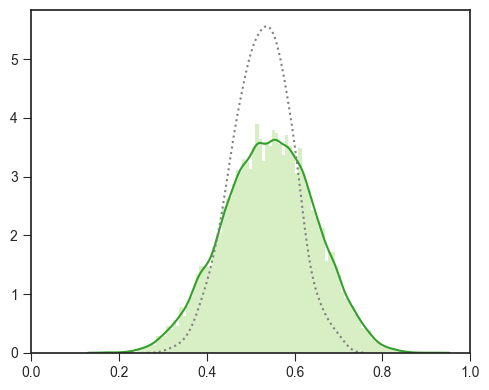

0.5418572841508669


In [69]:
plt.figure(figsize=(5, 4))
plt.hist(
    theta_samples[1, 50000:], 
    bins=100, 
    color=colors[2], 
    density=True,  
    edgecolor='none',
    alpha=0.5
)
sns.kdeplot(theta_samples[1,50000:], linewidth=1.5, color=colors[3])
sns.kdeplot(stats.beta(29.2, 26.2).rvs(1000),linewidth=1.5, color='grey', linestyle=':')

plt.xlim(0,1)
plt.ylabel('')
plt.tight_layout()
plt.show()

print(np.mean(theta_samples[1, 50000:]))

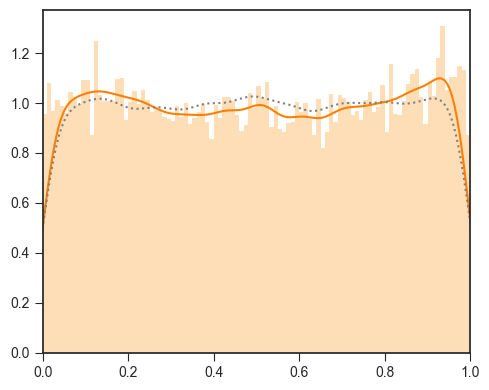

0.4755772688059763


In [82]:
plt.figure(figsize=(5, 4))
plt.hist(
    theta_samples[2, :], 
    bins=100, 
    color=colors[6], 
    density=True,  
    edgecolor='none',
    alpha=0.5
)
sns.kdeplot(theta_samples[2,:], linewidth=1.5, color=colors[7])
sns.kdeplot(stats.uniform(0,1).rvs(50000),linewidth=1.5, color='grey', linestyle=':')

plt.xlim(0,1)
plt.ylabel('')
plt.tight_layout()
plt.show()

print(np.median(theta_samples[2, 50000:]))

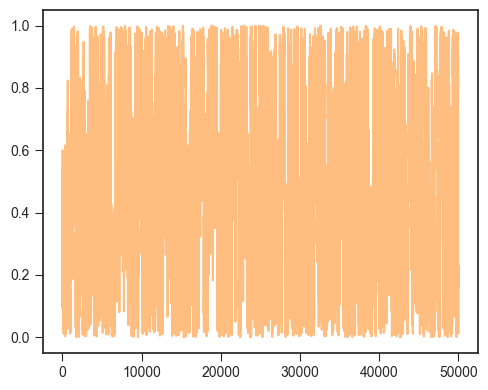

In [89]:
plt.figure(figsize=(5, 4))

plt.plot(theta_samples[2,50000:], color=colors[7], alpha=0.5)
plt.tight_layout()
plt.show()

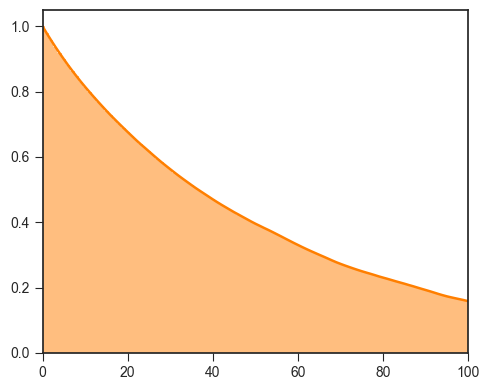

In [93]:
from statsmodels.tsa.stattools import acf

autocorr = acf(theta_samples[2,50000:], nlags=100, fft=True)

plt.figure(figsize=(5, 4))
plt.plot(autocorr, color=colors[7], linewidth=1.8)
plt.bar(range(100+1), autocorr, color=colors[7], width=1, alpha=0.5)

plt.xlim(0,100)
plt.tight_layout()
plt.show()

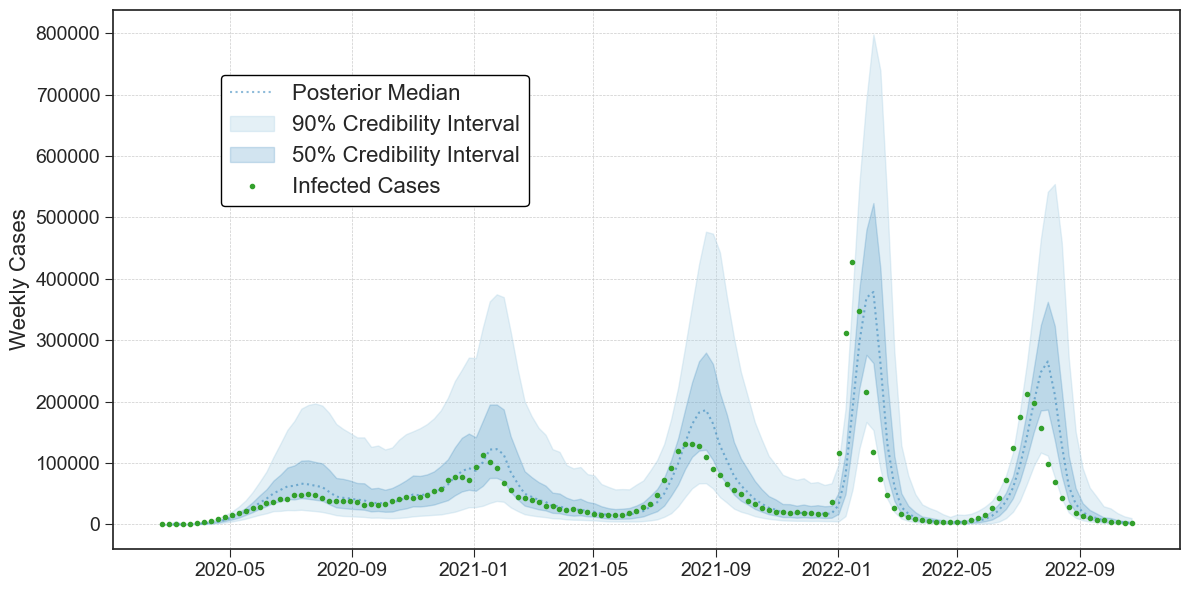

In [79]:
infections_lineage = weekly_trajectories[:,50000:]

infections_median = np.median(infections_lineage, axis=1)
# Compute the 5th and 95th percentiles for the 90% probability interval
infections_5th = np.percentile(infections_lineage, 5, axis=1)
infections_95th = np.percentile(infections_lineage, 95, axis=1)

infections_25th = np.percentile(infections_lineage, 25, axis=1)
infections_75th = np.percentile(infections_lineage, 75, axis=1)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

plt.plot(weekly_covid_df['date'][:140],infections_median, color=colors[1], alpha=0.5, linestyle=':', label='Posterior Median')
plt.fill_between(weekly_covid_df['date'][:140], infections_5th, infections_95th, 
                  color=colors[0], alpha=0.3, label='90% Credibility Interval')
plt.fill_between(weekly_covid_df['date'][:140], infections_25th, infections_75th, 
                  color=colors[1], alpha=0.2, label='50% Credibility Interval')
plt.plot(weekly_covid_df['date'][:140],Y_obs, color=colors[3], label='Infected Cases', marker='o', linewidth=0, markersize=3)
plt.legend(
    bbox_to_anchor=(0.4, 0.9),
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.ylabel('Weekly Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [84]:
import os
import pickle

# Define the folder path
data_folder = '/Users/ro/Desktop/UQ Chapter/'

# Define the full path for the file
file_path = os.path.join(data_folder, 'test_run_results.pkl')

# Load the pickle file
with open(file_path, 'rb') as f:
    results = pickle.load(f)

# Access the variables
r_theta_samples = results['theta_samples']
r_weekly_trajectories = results['weekly_trajectories']
r_vector_trajectories = results['vector_trajectories']
r_loglikelihoods = results['loglikelihoods']
r_acceptance_count = results['acceptance_count']
r_rejected_count = results['rejected_count']
r_AccRate = results['AccRate']

print("Data loaded successfully!")
print(f"Keys in results: {list(results.keys())}")

Data loaded successfully!
Keys in results: ['theta_samples', 'weekly_trajectories', 'vector_trajectories', 'loglikelihoods', 'acceptance_count', 'rejected_count', 'AccRate']


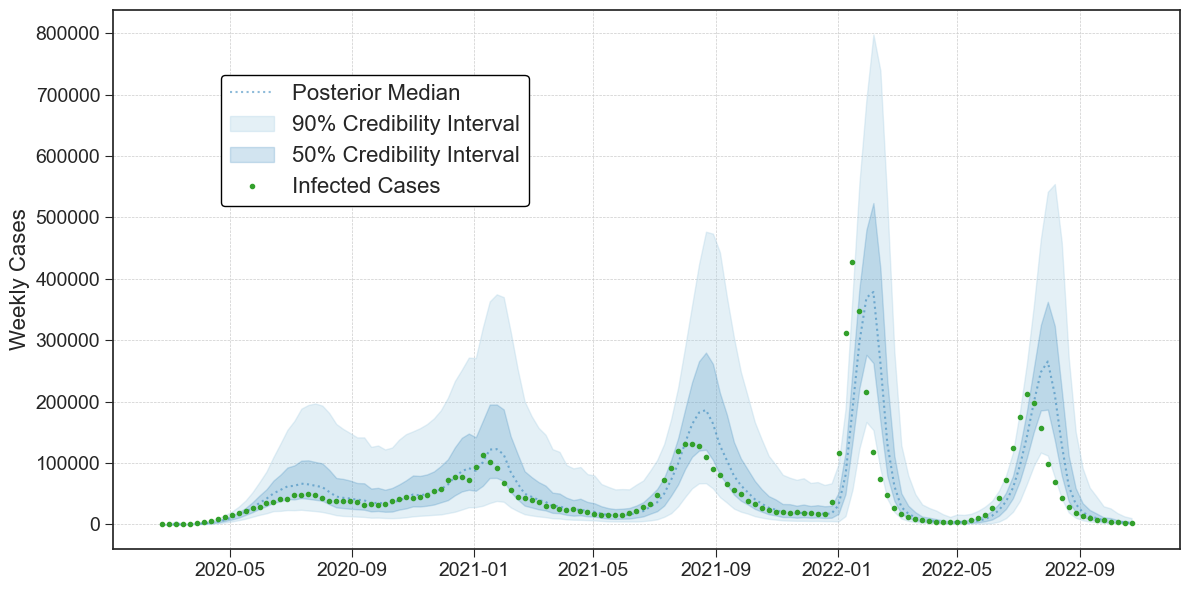

In [95]:
infections_lineage = r_weekly_trajectories[:,50000:]

infections_median = np.median(infections_lineage, axis=1)
# Compute the 5th and 95th percentiles for the 90% probability interval
infections_5th = np.percentile(infections_lineage, 5, axis=1)
infections_95th = np.percentile(infections_lineage, 95, axis=1)

infections_25th = np.percentile(infections_lineage, 25, axis=1)
infections_75th = np.percentile(infections_lineage, 75, axis=1)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

plt.plot(weekly_covid_df['date'][:140],infections_median, color=colors[1], alpha=0.5, linestyle=':', label='Posterior Median')
plt.fill_between(weekly_covid_df['date'][:140], infections_5th, infections_95th, 
                  color=colors[0], alpha=0.3, label='90% Credibility Interval')
plt.fill_between(weekly_covid_df['date'][:140], infections_25th, infections_75th, 
                  color=colors[1], alpha=0.2, label='50% Credibility Interval')
plt.plot(weekly_covid_df['date'][:140],Y_obs, color=colors[3], label='Infected Cases', marker='o', linewidth=0, markersize=3)
plt.legend(
    bbox_to_anchor=(0.4, 0.9),
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.ylabel('Weekly Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()